<a href="https://colab.research.google.com/github/SIM-777/Modifed-LeNET-CNN-model/blob/model-definition/Modified_Lenet_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,InputLayer,Flatten,BatchNormalization,Input,Layer,Resizing,Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.metrics import TruePositives,TrueNegatives,FalsePositives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import drive
import tensorflow.keras.callbacks
import tensorflow_probability as tfp
import albumentations as A
import cv2

In [2]:
#TEST DATASET.CAN LOAD OTHER DATA OR PREPARE ONE.
dataset=tfds.load("malaria",split="train",as_supervised=True,shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteJDV9IY/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
# FUNCTION TO SPLIT MAIN DATASET INTO TRAIN,VALIDATION AND TEST DATASETS
def split_data(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  train_data=dataset.take(int(TRAIN_RATIO*len(dataset)))
  val_dataset=dataset.skip(int(VAL_RATIO*len(dataset)))
  val_data=val_dataset.take(int(VAL_RATIO*len(val_dataset)))
  test_data=val_dataset.skip(int(VAL_RATIO*len(val_dataset)))
  test_data=val_dataset.take(int(TRAIN_RATIO*len(val_dataset)))
  return train_data,val_data,test_data

In [4]:
# IMAGE PREPORCESSING TO RESIZE AND RESCALE THE LAYER
IM_SIZE=224
def resize_rescale(image,label):
   IM_SIZE=224
   return (tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label)




In [5]:
# SPLIT THE DATA BASED ON THE RATIOS GIVEN
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1
train_data,val_data,test_data=(split_data(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO))


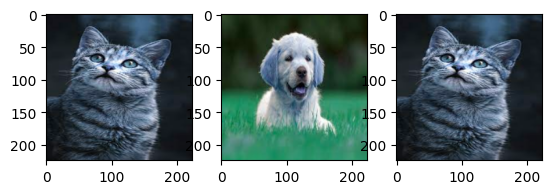

In [6]:
# SOME TESTING OF DATA WITH IMAGE AUGMENTATION.CAN INGNORE THIS SECTION
IM_SIZE=224
plt.subplot(1,3,1)
image1=cv2.imread("/content/drive/MyDrive/Tensorflow images/cat.jpg.jfif")
plt.imshow(cv2.resize(image1,(IM_SIZE,IM_SIZE)))
cat_image=cv2.resize(image1,(IM_SIZE,IM_SIZE))
plt.subplot(1,3,2)
image2=cv2.imread("/content/drive/MyDrive/Tensorflow images/dog.jfif")
plt.imshow(cv2.resize(image2,(IM_SIZE,IM_SIZE)))


image3=tf.image.crop_to_bounding_box(image2,75,100, 100, 100)
plt.subplot(1,3,3)
plt.imshow(image3)
image4=tf.image.pad_to_bounding_box(
    image3, 75, 100, IM_SIZE, IM_SIZE
)
plt.imshow(image4)

crop_cat=tf.image.crop_to_bounding_box(image2,75,100, 100, 100)
padded_cat=tf.image.pad_to_bounding_box(
    crop_cat, 75, 100, IM_SIZE, IM_SIZE
)

mixed_image=cat_image-padded_cat+image4
plt.imshow(mixed_image)


In [30]:
 # DRAW A BOUNDING BOX THAT DEFINES THE COORDINATES OF THE TOP LEFT CORNER OF THE BOUNDING BOX (top_left_x,top_left_y)AND THE WIDTH AND HEIGHT OF THE BOUNDING BOX (rw,rh) BASED ON THE LAMBDA VALUE PROVIDED.
 def draw_box(lamda):

  rx = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
  ry=tf.cast(tfp.distributions.Uniform(0,IM_SIZE).sample(1)[0],dtype=tf.int32)
  print(rx,ry)
  rw=tf.cast(IM_SIZE * tf.math.sqrt(1-lamda),dtype=tf.int32)
  rh=tf.cast(IM_SIZE * tf.math.sqrt(1-lamda),dtype=tf.int32)

  top_left_x=tf.clip_by_value(rx-rw//2,0,IM_SIZE) #keep the bounding within the frame
  top_left_y=tf.clip_by_value(ry-rh//2,0,IM_SIZE)

  bottom_right_x=tf.clip_by_value(rx+rw//2,0,IM_SIZE) #keep the bounding within the frame
  bottom_right_y=tf.clip_by_value(ry+rh//2,0,IM_SIZE)

  rw=bottom_right_x-top_left_x
  if rw==0:
    rw=1
  rh=bottom_right_y-top_left_y
  if(rh==0):
    rh=1
  return top_left_y,top_left_x,rw,rh




In [34]:
# IMAGE AUGMENTATION FUNCTION THAT MIXES PORTION OF ONE IMAGE WITH ANOTHER BASED ON THE lambda VALUE CALCULATED FROM A BETA DISTRIBUTION.USES THE draw_box FUNCTION.
def cut_mix_augmentation(train_dataset1,train_dataset2):
  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]
  IM_SIZE=224
  (image1,label1),(image2,label2)=train_dataset1,train_dataset2
  ry,rx,rh,rw=draw_box(lamda)
  crop1=tf.image.crop_to_bounding_box(image1,ry,rx,rw,rh)
  pad1=tf.image.pad_to_bounding_box(
    crop1, ry,rx,IM_SIZE, IM_SIZE
)

  crop2=tf.image.crop_to_bounding_box(image2,ry,rx,rw,rh)
  pad2=tf.image.pad_to_bounding_box(
  crop2, ry, rx, IM_SIZE, IM_SIZE
)
  lamda= tf.cast(1-((rw*rh)/(IM_SIZE*IM_SIZE)),dtype=tf.float32)
  label=lamda*(tf.cast(label1,dtype=tf.float32))+ (1-lamda)*(tf.cast(label2,dtype=tf.float32))
  image=image1-pad1 + pad2
  return image,label

In [37]:
# PREPARE THE DATASETS
train_dataset1=train_data.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resize_rescale)
train_dataset2=train_data.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resize_rescale)
mixed_data=(tf.data.Dataset.zip((train_dataset1,train_dataset2)))
mixed_dataset=mixed_data.map(cut_mix_augmentation).batch(32).prefetch(tf.data.AUTOTUNE)



Tensor("Cast:0", shape=(), dtype=int32) Tensor("Cast_1:0", shape=(), dtype=int32)


In [ ]:
# TESTING DATASETS.CAN IGNORE THIS SECTION
image=mixed_dataset.next_iter()

AttributeError: '_PrefetchDataset' object has no attribute 'next_iter'

In [24]:
# DEFINE THE METRICS TO OBSERVE DURING MODEL TRAINING
metrics=[TruePositives(name='tp'),TrueNegatives(name="tn"),FalsePositives(name="fp"),FalseNegatives(name="fn"),BinaryAccuracy(name="bn"),Precision(name="precision"),Recall(name="recall"),AUC(name="auc")]

In [28]:
# DEFINE A CNN MODEL BASED ON THE leNet ARCHITECTURE  (LeCun et al., 1998).MODIFIED THE ORIGNAL ARCHITECTURE BY USING Batch Normalization LAYERS FOR BETTER PERFORMANCE
IM_SIZE=224

lenet_model=tf.keras.Sequential([

                                InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),

                                Conv2D(filters=6,kernel_size=3,strides=1,padding="valid",activation="relu"),
                                BatchNormalization(),
                                MaxPool2D (pool_size=2,strides=2),
                                Conv2D(filters=16,kernel_size=3,strides=1,padding="valid",activation="relu"),
                                BatchNormalization(),
                                MaxPool2D (pool_size=2,strides=2),
                                Flatten(),
                                Dense(100),
                                BatchNormalization(),
                                Dense(10),
                                BatchNormalization(),
                                Dense(1)
                                 ])


lenet_model.compile(optimizer=Adam(learning_rate=0.01),loss=BinaryCrossentropy(),metrics=metrics)
lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [36]:
# TEST SECTION.CAN IGNORE
image,_=next(iter(mixed_dataset))
plt.imshow(image[0])

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} assertion failed: [target_height must be > 0.]
	 [[{{node crop_to_bounding_box/Assert_3/Assert}}]] [Op:IteratorGetNext] name: 

In [32]:
val_dataset=val_data.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resize_rescale).batch(32).prefetch(tf.data.AUTOTUNE)

In [38]:
# FIT THE MODEL WITH THE DATASET
lenet_model.fit(mixed_dataset,validation_data=val_dataset,verbose=1,epochs=10)

Epoch 1/10
226/689 [========>.....................] - ETA: 10:31 - loss: 2.2205 - tp: 2501.0000 - tn: 1230.0000 - fp: 601.0000 - fn: 2900.0000 - bn: 0.3056 - precision: 0.8063 - recall: 0.4631 - auc: 0.5753

KeyboardInterrupt: 